# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

In [1]:
import xsimlab as xs
import numpy as np

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [4]:
from phydra.processes.main import GekkoCore, GekkoContext, GekkoSequentialSolve, Time

from phydra.processes.statevars import StateVariable, FunctionalGroup

from phydra.processes.fluxes import (InFlux, LinearExchangeFlux,LinearLossFlux, MonodUptake, Growth_MultiLim, 
                                    GML_MonodUptake, GML_EppleyTempLim, GML_SteeleLightLim,
                                    GrazingFlux, GrazingFlux_MultiRessource,
                                    QuadraticLossFlux, QuadraticExchangeFlux, Mixing, Upwelling)

from phydra.processes.forcings import ConstantForcing, SinusoidalForcing, GlobalSlabClimatologyForcing

from phydra.processes.paramsetup import GrowthParameterSetup

In [5]:
from phydra.processes.forcings import Forcing

In [6]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.91.gafa18aa.dirty


In [8]:
MODEL = xs.Model({
                # CORE
                'core':GekkoCore, 
                'solver':GekkoSequentialSolve, 

                'time':Time, 
                
                # STATE VARIABLES
                'N':StateVariable, 
                'P':StateVariable,
                #'Z':StateVariable, 
                #'D':StateVariable,
                
                # FLUXES
                # setup classmethod allows multiple instances of Growth_MultiLim process
                # and GML_... processes in same model
                  # Pro: flexible, Con: less understandable code
                'growth':Growth_MultiLim.setup('_P'),
                'monod':GML_MonodUptake.setup('_P'),
                #'eppley':GML_EppleyTempLim.setup('_P'),
                #'steele':GML_SteeleLightLim.setup('_P'),

                # note, grazing does not include setup class method (only 1 instance possible)
                  # (design choice not yet settled)
                #'grazing':GrazingFlux_MultiRessource,
                
                'P_mortality':LinearLossFlux,
                #'P_quadmortality':QuadraticExchangeFlux,
                #'Z_mortality':LinearExchangeFlux,
                #'Z_quadmortality':QuadraticLossFlux,
    
                #'D_remin':LinearExchangeFlux,
    
                #'Mixing': Mixing,
    
                'N_upwelling':Upwelling,
                
                # FORCING
                'N0':GlobalSlabClimatologyForcing,
                #'Temp':GlobalSlabClimatologyForcing,
                #'I0':GlobalSlabClimatologyForcing,
                'MLD':GlobalSlabClimatologyForcing,
                })

MODEL

<xsimlab.Model (11 processes, 23 inputs)>
core
solver
time
    days             [in] ('time',) time in days
N
    initVal          [in] initial value of component
P
    initVal          [in] initial value of component
monod
    halfsat          [in] half saturation constant for Monod growth
MLD
    smooth           [in] smoothing factor used to choose number of...
    lon              [in]
    dataset          [in] Options: 'n0x', 'mld', 'tmld', 'par'
    rbb              [in]
    lat              [in]
N0
    lon              [in]
    dataset          [in] Options: 'n0x', 'mld', 'tmld', 'par'
    rbb              [in]
    lat              [in]
    smooth           [in] smoothing factor used to choose number of...
growth
    source_label     [in]
    sink_label       [in]
    mumax            [in] maximum growth rate
P_mortality
    SV_label         [in]
    rate             [in] quadratic loss rate
N_upwelling
    SV_label         [in]
    FX_label_N0      [in] N0 forcing label
    FX_

In [12]:
in_ds = phydra_setup(model=MODEL,
                        input_vars={
                            'time__days': ('time', np.arange(0, 365*5)),
                            
                            'N':{'initVal':0.01},
                            'P':{'initVal':.01},
                            #'Z':{'initVal':.01},
                            #'D':{'initVal':.01},
                            
                            'growth':{'source_label':'N',
                                      'sink_label':'P',
                                      'mumax':1.},
                            'monod':{'halfsat':0.5},
                            #'eppley':{'FX_label':'Temp',
                            #          'exponent':0.063},
                            #'steele':{'FX_label_I0':'I0',
                            #          'FX_label_MLD':'MLD',
                            #          'IOpt':20.,
                            #          'kw':0.04,
                            #          'kc':0.03},
                            
                            #'grazing':{'source_labels':['P','D'],
                            #           'sink_label':'Z',
                            #           'egested2_label':'D',
                            #           'excreted2_label':'N',
                                       
                            #           'Imax':1.,
                            #           'kZ':0.6,
                            #           'epsilon':0.75,
                            #           'beta':0.69,
                                      
                            #           'feed_prefs':[0.67, 0.33]},
                            
                            'P_mortality':{'SV_label':'P',
                                           'rate':0.15},
                            
                            #'P_mortality':{'source_label':'P',
                            #               'sink_label':'D',
                            #               'rate':0.015},
                            
                            #'P_quadmortality':{'source_label':'P',
                            #               'sink_label':'D',
                            #               'rate':0.025},
                            
                            #'Z_mortality':{'source_label':'Z',
                            #               'sink_label':'D',
                            #               'rate':0.02},
                            
                            #'Z_quadmortality':{'SV_label':'Z',
                            #               'rate':0.34},
                            
                            #'D_remin':{'source_label':'D',
                            #           'sink_label':'N',
                            #           'rate':0.06},
                            
                            #'Mixing':{'SV_labels':['P','Z','D'],
                            #          'FX_label_MLD':'MLD',
                            #          'kappa':0.1},
                            
                            'N_upwelling':{'SV_label':'N',
                                      'FX_label_MLD':'MLD',
                                      'FX_label_N0':'N0',
                                      'kappa':0.1},
                            
                            'N0':{'lat':40,'lon':20,'rbb':2,'smooth':1,
                                   'dataset':'n0x'},
                            #'Temp':{'lat':40,'lon':20,'rbb':2,'smooth':100,
                            #       'dataset':'tmld'},
                            #'I0':{'lat':40,'lon':20,'rbb':2,'smooth':.01,
                            #       'dataset':'par'},
                            'MLD':{'lat':40,'lon':20,'rbb':2,'smooth':100,
                                   'dataset':'mld'}

                        },
                        output_vars={
                            # State Variables
                            'N__value':None,
                            'P__value':None,
                            #'Z__value':None,
                            #'D__value':None,
                            
                            # Fluxes
                            'growth__value':None,
                            'P_mortality__value':None,
                            #'P_quadmortality__value':None,
                            #'Z_mortality__value':None,
                            #'Z_quadmortality__value':None,
                            #'grazing__values':None,
                            
                            # Forcing
                            'N0__value':None,
                            'MLD__value':None,
                            'MLD__deriv':None,
                            #'Temp__value':None,
                            #'I0__value':None,
                            
                            # Forcing Fluxes
                            'N_upwelling__value':None,
                            #'Mixing__values':None
                        })

In [13]:
with MODEL:
    out_ds = in_ds.xsimlab.run()

initializing model core
Initializing Model Time
state variable N is initialized
state variable P is initialized
forcing MLD is initialized
forcing N0 is initialized
flux growth of P consuming N is initialized
flux P_mortality acting on P is initialized
flux N_upwelling acting on N is initialized
[0.49041328 0.49489211 0.49934794 ... 0.47886287 0.48173553 0.48455703]
assembling equations for state variable N
defaultdict(<class 'list'>, {'N': [(-((((1.0)*(((n)/((0.5+n))))))*(p))), (((n0-n))*((((hpos2+0.1))/(mld))))], 'P': [((((1.0)*(((n)/((0.5+n))))))*(p)), (-((p)*(0.15)))]})
assembling equations for state variable P
defaultdict(<class 'list'>, {'N': [(-((((1.0)*(((n)/((0.5+n))))))*(p))), (((n0-n))*((((hpos2+0.1))/(mld))))], 'P': [((((1.0)*(((n)/((0.5+n))))))*(p)), (-((p)*(0.15)))]})
['time', 'n', 'p']
Running solver now
Model was solved in 16.16 seconds
finalizing gekko core: cleanup


In [14]:
print(out_ds)

<xarray.Dataset>
Dimensions:                    (clock: 2, time: 1825)
Coordinates:
  * clock                      (clock) int64 0 1
  * time                       (time) int64 0 1 2 3 4 ... 1821 1822 1823 1824
Data variables:
    MLD__dataset               <U3 'mld'
    MLD__deriv                 (time) float64 0.5669 0.548 ... 0.5909 0.5747
    MLD__lat                   int64 40
    MLD__lon                   int64 20
    MLD__rbb                   int64 2
    MLD__smooth                int64 100
    MLD__value                 (time) float64 52.1 52.66 53.19 ... 51.37 51.96
    N0__dataset                <U3 'n0x'
    N0__lat                    int64 40
    N0__lon                    int64 20
    N0__rbb                    int64 2
    N0__smooth                 int64 1
    N0__value                  (time) float64 0.4904 0.4949 ... 0.4817 0.4846
    N__initVal                 float64 0.01
    N__value                   (time) float64 0.01 0.01587 ... 0.2593 0.2599
    N_upwelling__F

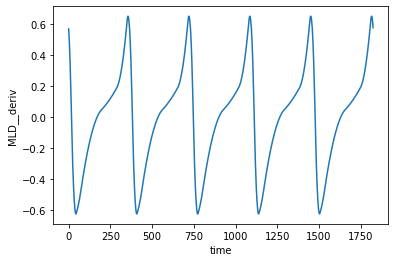

In [15]:
out_ds.MLD__deriv.plot.line(x='time')

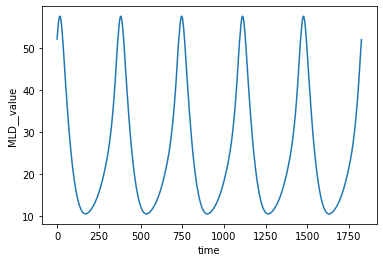

In [16]:
out_ds.MLD__value.plot.line(x='time')

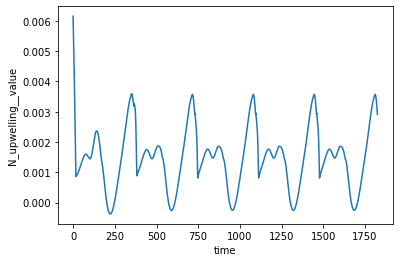

In [17]:
out_ds.N_upwelling__value.plot.line(x='time')

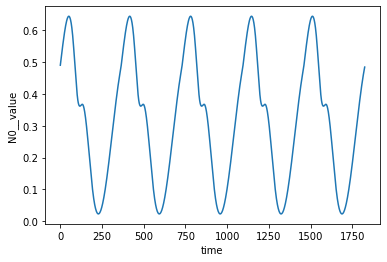

In [18]:
out_ds.N0__value.plot.line(x='time')

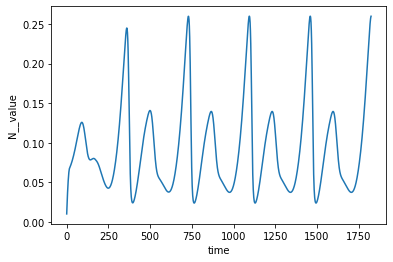

In [19]:
out_ds.N__value.plot.line(x='time')

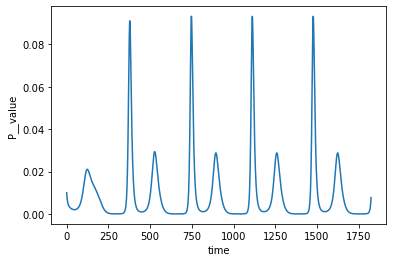

In [20]:
out_ds.P__value.plot.line(x='time')

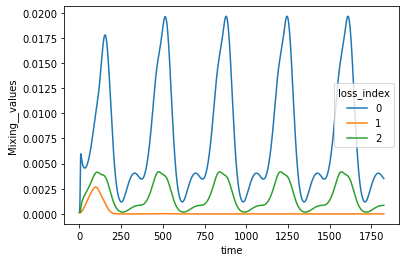

In [12]:
out_ds.Mixing__values.plot.line(x='time')

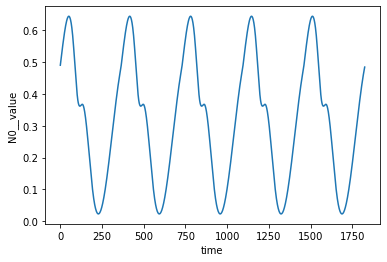

In [13]:
out_ds.N0__value.plot.line(x='time')
#out_ds.Temp__value.plot.line(x='time')
#out_ds.MLD__value.plot.line(x='time')
#out_ds.I0__value.plot.line(x='time')

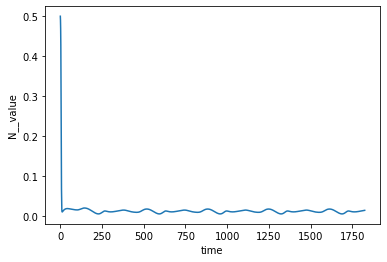

In [14]:
out_ds.N__value.plot.line(x='time')

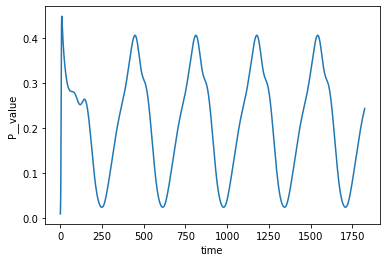

In [15]:
out_ds.P__value.plot.line(x='time')

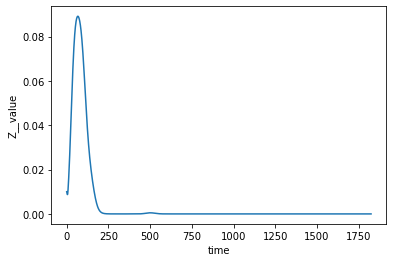

In [16]:
out_ds.Z__value.plot.line(x='time')

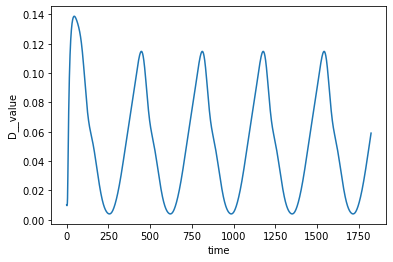

In [17]:
out_ds.D__value.plot.line(x='time')

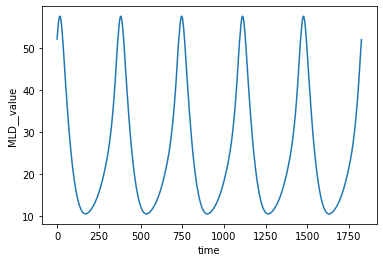

In [17]:
out_ds.MLD__value.plot.line(x='time')

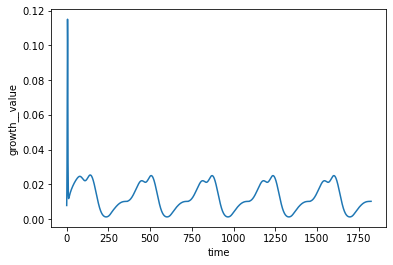

In [18]:
out_ds.growth__value.plot.line(x='time')

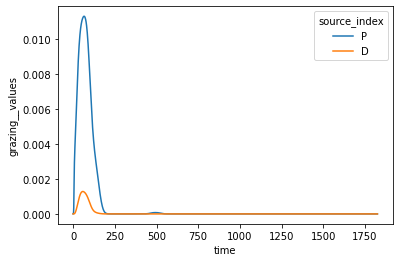

In [19]:
out_ds.grazing__values.plot.line(x='time')

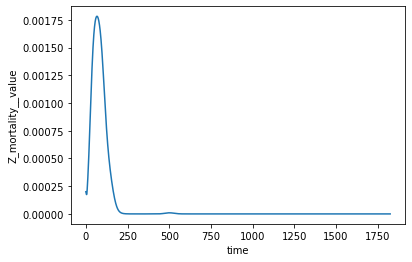

In [20]:
out_ds.Z_mortality__value.plot.line(x='time')

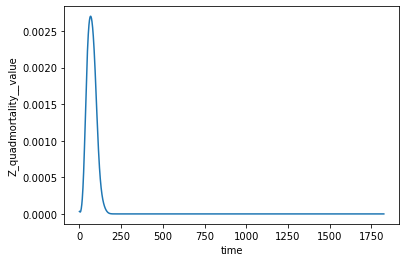

In [21]:
out_ds.Z_quadmortality__value.plot.line(x='time')

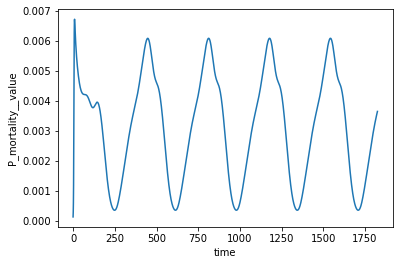

In [22]:
out_ds.P_mortality__value.plot.line(x='time')

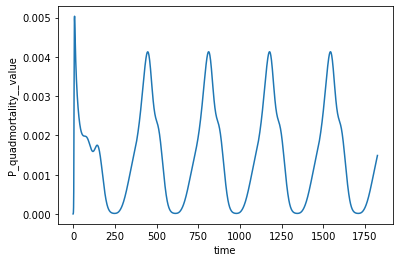

In [23]:
out_ds.P_quadmortality__value.plot.line(x='time')

In [21]:
##########################

# OLD CODE

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra as phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [7]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, Time, make_Component
from phydra.processes.environments import BaseEnvironment, Slab
from phydra.processes.fluxes import (BaseFlux, LimitedGrowth_Monod, 
                                     LimitedGrowth_MonodTempLight,  
                                     LinearMortality, 
                                     HollingTypeIII, make_flux, make_multigrazing)
from phydra.processes.forcingfluxes import (LinearMortalityClosure, Mixing, Sinking, 
                                            Upwelling, make_FX_flux)
from phydra.processes.forcing import (SinusoidalMLD, ConstantN0, WOA2018_MLD, 
                                      WOA2018_N0, MODISaq_PAR, WOA2018_Tmld, 
                                      ConstantPAR, ConstantTemp)
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [8]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [9]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.82.g7e99bc8.dirty


In [12]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N', comp_type=Component), 'P':make_Component('Phytoplankton','P', comp_type=Component),
    'Z':make_Component('Zooplankton','Z', comp_type=Component), 'D':make_Component('Detritus','D', comp_type=Component),
    'Env':Slab, 
    
    # Fluxes
    'P_Growth':make_flux(LimitedGrowth_Monod, 'G'), 
     
    'P_LinMortality':make_FX_flux(LinearMortalityClosure, 'P'),
    
    'Grazing':make_multigrazing(HollingTypeIII, 'X'), 
    
    # Closure (i.e. output from system)
    'Z_LinMortality':make_FX_flux(LinearMortalityClosure, 'Z'),
    
    # ForcingFluxes
    #'Sinking':make_FX_flux(Sinking, 'S'),
    'Upwelling':make_FX_flux(Upwelling, 'U'),
    
    'MLD':WOA2018_MLD, 
    'N0':ConstantN0, 
    'PAR':MODISaq_PAR,
    'Temp':WOA2018_Tmld,
    
    'solver':GekkoSolve
})

model

<xsimlab.Model (19 processes, 41 inputs)>
context
time
    days               [in] ('time',) time in days
grid
    shape              [in]
    length             [in]
ibcs
    ibc                [in] Initial Boundary Conditions
N
    init               [in]
    dim                [in]
P
    dim                [in]
    init               [in]
Z
    dim                [in]
    init               [in]
D
    dim                [in]
    init               [in]
P_Growth
    halfsat_min        [in] half-saturation constant of nutrient up...
    halfsat_max        [in] half-saturation constant of nutrient up...
    mu_max             [in] Maximum growth rate of component
    C_label            [in] label of component that grows
    mu_min             [in] Maximum growth rate of component
    R_label            [in] label of ressource component that is co...
Temp
    lat                [in]
    smooth             [in] smoothing factor used to choose number ...
    rbb                [in]
    lo

In [13]:
model.index_vars 


[('time', 'time'),
 ('N', 'N'),
 ('P', 'P'),
 ('Z', 'Z'),
 ('D', 'D'),
 ('Env', 'components'),
 ('Env', 'fluxes'),
 ('Env', 'forcingfluxes'),
 ('Env', 'forcings'),
 ('P_Growth', 'G'),
 ('P_LinMortality', 'P'),
 ('Grazing', 'X'),
 ('Z_LinMortality', 'Z'),
 ('Upwelling', 'U')]

In [14]:
ForcingLocation = {
    'lat':40,
    'lon':20,
    'rbb':2, 
    'smooth':100
}
ForcingLocationNOSMOOTH = ForcingLocation.copy()
ForcingLocationNOSMOOTH['smooth'] = 1

In [15]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 365*3)), #365*
        
        'N':{'dim':1,'init':.1}, 
        'P':{'dim':1,'init':.1},
        'Z':{'dim':1,'init':0.1},
        'D':{'dim':1,'init':2.1},
        
     'P_Growth':{'mu_min':0.7,
                   'mu_max':0.73,
               'halfsat_min':0.67,
               'halfsat_max':0.7,
               'R_label':'N',
               'C_label':'P'
                   
                #'kw':0.04,
                #'kc':0.03,
                #'OptI':30
                   },
        
        'Grazing':{'Imax':0.5,
               'halfsat':1.,
               'R_feed_prefs':[0.67, 0.33],
               'R_labels':['P','D'],
               #'C_labels':['Z']},
               #'R_label':'P',
               'C_label':'Z'},
        
                
        'P_LinMortality':{'mortality_rate':0.1,
               'C_labels':['P']},
        
        'Z_LinMortality':{'mortality_rate':0.1,
               'C_labels':['Z']},
        
        #'Sinking':{'kappa':0.,
        #       'C_labels':['P']},
        
        'Upwelling':{'kappa':0.,
               'C_labels':['N']},
        
        'PAR':ForcingLocationNOSMOOTH,
        'Temp':ForcingLocationNOSMOOTH,
        'N0__value':2,
        'MLD':ForcingLocation
    },
    output_vars={
        'Env__comp_output':None,
        'Env__flux_output':None,
        'Env__fxflux_output':None,
        'Env__forcing_output':None
    }
                 )

KeyError: "('Grazing', 'R_feed_prefs'), ('Grazing', 'R_labels') is/are not valid key(s) for input variables in model <xsimlab.Model (19 processes, 41 inputs)>\ncontext\ntime\n    days               [in] ('time',) time in days\ngrid\n    shape              [in]\n    length             [in]\nibcs\n    ibc                [in] Initial Boundary Conditions\nN\n    init               [in]\n    dim                [in]\nP\n    dim                [in]\n    init               [in]\nZ\n    dim                [in]\n    init               [in]\nD\n    dim                [in]\n    init               [in]\nP_Growth\n    halfsat_min        [in] half-saturation constant of nutrient up...\n    halfsat_max        [in] half-saturation constant of nutrient up...\n    mu_max             [in] Maximum growth rate of component\n    C_label            [in] label of component that grows\n    mu_min             [in] Maximum growth rate of component\n    R_label            [in] label of ressource component that is co...\nTemp\n    lat                [in]\n    smooth             [in] smoothing factor used to choose number ...\n    rbb                [in]\n    lon                [in]\nGrazing\n    Imax               [in] maximum grazing rate for consumer\n    C_label            [in] label of component that grazes\n    R_label            [in] labels of components that is grazed upon\n    halfsat            [in] label of component that grazes\nMLD\n    rbb                [in]\n    lon                [in]\n    smooth             [in] smoothing factor used to choose number ...\n    lat                [in]\nN0\n    value              [in] value of the constant forcing\nUpwelling\n    kappa              [in] constant mixing coefficient\n    C_labels           [in] u label of component(s) that grows\nZ_LinMortality\n    mortality_rate     [in] mortality rate of component\n    C_labels           [in] z label of component(s) that grows\nPAR\n    lat                [in]\n    smooth             [in] smoothing factor used to choose number ...\n    rbb                [in]\n    lon                [in]\nP_LinMortality\n    mortality_rate     [in] mortality rate of component\n    C_labels           [in] p label of component(s) that grows\nEnv\nsolver\n"

In [11]:
with model:
    out_ds = in_ds.xsimlab.run()

NameError: name 'in_ds' is not defined

In [12]:
out_ds

<xarray.Dataset>
Dimensions:                         (D: 1, G: 1, N: 1, P: 1, R: 2, U: 1, X: 2, Z: 1, clock: 2, components: 4, fluxes: 3, forcingfluxes: 3, forcings: 4, p: 1, time: 1095, u: 1, z: 1)
Coordinates:
  * D                               (D) <U1 'D'
  * G                               (G) <U14 'P_Growth-N-2-P'
  * N                               (N) <U1 'N'
  * P                               (P) <U1 'P'
  * U                               (U) <U11 'Upwelling-N'
  * X                               (X) <U13 'Grazing-P-2-Z' 'Grazing-D-2-Z'
  * Z                               (Z) <U1 'Z'
  * clock                           (clock) int64 0 1
  * components                      (components) <U1 'N' 'P' 'Z' 'D'
  * fluxes                          (fluxes) <U14 'Grazing-P-2-Z' ... 'P_Growth-N-2-P'
  * forcingfluxes                   (forcingfluxes) <U16 'P_LinMortality-P' ... 'Upwelling-N'
  * forcings                        (forcings) <U4 'N0' 'Temp' 'MLD' 'PAR'
  * time                            (time) int64 0 1 2 3 ... 1091 1092 1093 1094
Dimensions without coordinates: R, p, u, z
Data variables:
    D__dim                          int64 1
    D__init                         float64 2.1
    Env__comp_output                (components, time) float64 0.1 ... 2.2
    Env__flux_output                (fluxes, time) float64 0.02 ... 0.02367
    Env__forcing_output             (forcings, time) float64 2.0 2.0 ... 13.08
    Env__fxflux_output              (forcingfluxes, time) float64 -0.01 ... 0.02378
    Grazing__C_label                <U1 'Z'
    Grazing__Imax                   float64 0.5
    Grazing__R_feed_prefs           (R) float64 0.67 0.33
    Grazing__R_labels               (R) <U1 'P' 'D'
    Grazing__halfsat                float64 1.0
    MLD__lat                        int64 40
    MLD__lon                        int64 20
    MLD__rbb                        int64 2
    MLD__smooth                     int64 100
    N0__value                       int64 2
    N__dim                          int64 1
    N__init                         float64 0.1
    PAR__lat                        int64 40
    PAR__lon                        int64 20
    PAR__rbb                        int64 2
    PAR__smooth                     int64 1
    P_Growth__C_label               <U1 'P'
    P_Growth__R_label               <U1 'N'
    P_Growth__halfsat_max           float64 0.7
    P_Growth__halfsat_min           float64 0.67
    P_Growth__mu_max                float64 0.73
    P_Growth__mu_min                float64 0.7
    P_LinMortality__C_labels        (p) <U1 'P'
    P_LinMortality__mortality_rate  float64 0.1
    P__dim                          int64 1
    P__init                         float64 0.1
    Temp__lat                       int64 40
    Temp__lon                       int64 20
    Temp__rbb                       int64 2
    Temp__smooth                    int64 1
    Upwelling__C_labels             (u) <U1 'N'
    Upwelling__kappa                float64 0.0
    Z_LinMortality__C_labels        (z) <U1 'Z'
    Z_LinMortality__mortality_rate  float64 0.1
    Z__dim                          int64 1
    Z__init                         float64 0.1
    grid__length                    int64 1
    grid__shape                     int64 1
    ibcs__ibc                       float64 nan
    time__days                      (time) int64 0 1 2 3 ... 1091 1092 1093 1094

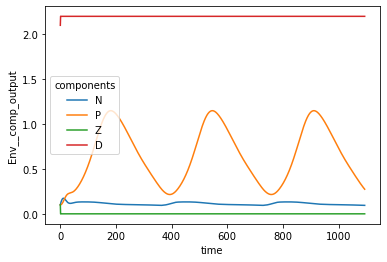

In [13]:
out_ds.Env__comp_output.plot.line(x='time')
#out_ds.Env__comp_output.isel(components=slice(1,-1)).sum(axis=0).plot.line(x='time')

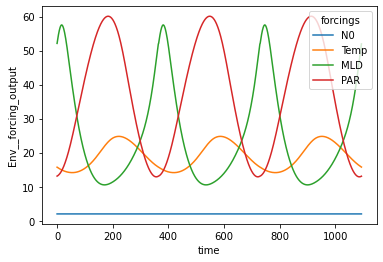

In [14]:
out_ds.Env__forcing_output.plot.line(x='time')

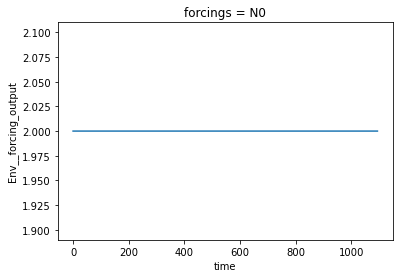

In [15]:
out_ds.Env__forcing_output.sel(forcings='N0').plot(x='time')  #, time=np.arange(300,400)

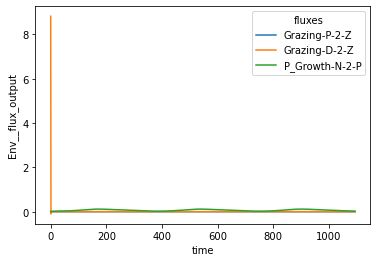

In [16]:
out_ds.Env__flux_output.plot.line(x='time')

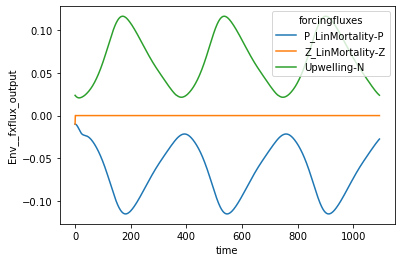

In [17]:
out_ds.Env__fxflux_output.plot.line(x='time')